In [ ]:
import gym

import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.distributions import Bernoulli

import matplotlib.pyplot as plt

In [ ]:
class PolicyNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNet, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim

        self.fc1 = nn.Linear(self.input_dim, 32)
        self.fc2 = nn.Linear(32, 32)
        self.output = nn.Linear(32, self.output_dim)

    def forward(self, x):
        output = F.relu(self.fc1(x))
        output = F.relu(self.fc2(output))
        output = torch.sigmoid(self.output(output))

        return output

In [ ]:
def convert_to_torch_variable(arr):
    """Converts a numpy array to torch variable"""
    return Variable(torch.from_numpy(arr).float())


def record_video():
    print("Recording video")
    recorder_cur_state = monitored_env.reset()
    recorder_cur_state = convert_to_torch_variable(recorder_cur_state)
    recorder_done = False
    while not recorder_done:
        recorder_action = Bernoulli(probs=policy_net(recorder_cur_state)).sample().numpy().astype(int)[0]

        recorder_next_state, _, recorder_done, _ = monitored_env.step(recorder_action)
        recorder_cur_state = convert_to_torch_variable(recorder_next_state)

In [ ]:
# Define environment
env = gym.make("CartPole-v0")
env.seed(0)

# Create environment monitor for video recording
video_monitor_callable = lambda _: True
monitored_env = gym.wrappers.Monitor(env, './cartpole_videos', force=True, video_callable=video_monitor_callable)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
bernoulli_action_dim = 1

# Initialize policy network
policy_net = PolicyNet(input_dim=state_dim, output_dim=bernoulli_action_dim)

# Hyperparameters
NUM_EPISODES = 500
GAMMA = 0.99
BATCH_SIZE = 5
LEARNING_RATE = 0.01

# Let baseline be 0 for now
baseline = 0.0

# Define optimizer
optimizer = torch.optim.RMSprop(policy_net.parameters(), lr=LEARNING_RATE)

[2019-03-26 19:52:33,982] Making new env: CartPole-v0
[2019-03-26 19:52:33,987] Clearing 12 monitor files from previous run (because force=True was provided)


In [ ]:
# Collect trajectory rewards for plotting purpose
traj_reward_history = []

# training loop
for ep_i in range(NUM_EPISODES):
    loss = 0.0

    # Record states, actions and discounted rewards of this episode
    states = []
    actions = []
    rewards = []
    cumulative_undiscounted_reward = 0.0

    for traj_i in range(BATCH_SIZE):
        time_step = 0
        done = False

        # initialize environment
        cur_state = env.reset()
        cur_state = convert_to_torch_variable(cur_state)

        discount_factor = 1.0
        discounted_rewards = []

        grad_log_params = []

        while not done:
            # Compute action probability using the current policy
            action_prob = policy_net(cur_state)

            # Sample action according to action probability
            action_sampler = Bernoulli(probs=action_prob)
            action = action_sampler.sample()
            action = action.numpy().astype(int)[0]

            # Record the states and actions -- will be used for policy gradient later
            states.append(cur_state)
            actions.append(action)

            # take a step in the environment, and collect data
            next_state, reward, done, _ = env.step(action)

            # Discount the reward, and append to reward list
            discounted_reward = reward * discount_factor
            discounted_rewards.append(discounted_reward)
            cumulative_undiscounted_reward += reward

            # Prepare for taking the next step
            cur_state = convert_to_torch_variable(next_state)

            time_step += 1
            discount_factor *= GAMMA

        # Finished collecting data for the current trajectory. 
        # Recall temporal structure in policy gradient.
        # Donstruct the "cumulative future discounted reward" at each time step.
        for time_i in range(time_step):
            # relevant reward is the sum of rewards from time t to the end of trajectory
            relevant_reward = sum(discounted_rewards[time_i:])
            rewards.append(relevant_reward)

    # Finished collecting data for this batch. Update policy using policy gradient.
    avg_traj_reward = cumulative_undiscounted_reward / BATCH_SIZE
    traj_reward_history.append(avg_traj_reward)

    if (ep_i + 1) % 10 == 0:
        print("Episode {}: Average reward per trajectory = {}".format(ep_i + 1, avg_traj_reward))

    if (ep_i + 1) % 100 == 0:
        record_video()

    optimizer.zero_grad()
    data_len = len(states)
    loss = 0.0

    # Compute the policy gradient
    for data_i in range(data_len):
        action_prob = policy_net(states[data_i])
        action_sampler = Bernoulli(probs=action_prob)

        loss -= action_sampler.log_prob(actions[data_i]) * (rewards[data_i] - baseline)
    loss /= float(data_len)
    loss.backward()
    optimizer.step()

Episode 10: Average reward per trajectory = 29.2
Episode 20: Average reward per trajectory = 36.2
Episode 30: Average reward per trajectory = 139.0
Episode 40: Average reward per trajectory = 200.0
Episode 50: Average reward per trajectory = 178.0
Episode 60: Average reward per trajectory = 200.0
Episode 70: Average reward per trajectory = 199.2
Episode 80: Average reward per trajectory = 200.0
Episode 90: Average reward per trajectory = 200.0


[2019-03-26 19:53:03,604] Starting new video recorder writing to /home/jenny/Documents/UofT/TA-CSC421/tutorials/cartpole_videos/openaigym.video.0.8404.video000000.mp4


Episode 100: Average reward per trajectory = 200.0
Recording video
Episode 110: Average reward per trajectory = 120.4
Episode 120: Average reward per trajectory = 127.2
Episode 130: Average reward per trajectory = 150.0
Episode 140: Average reward per trajectory = 200.0
Episode 150: Average reward per trajectory = 200.0
Episode 160: Average reward per trajectory = 200.0
Episode 170: Average reward per trajectory = 200.0
Episode 180: Average reward per trajectory = 200.0
Episode 190: Average reward per trajectory = 155.4


[2019-03-26 19:53:44,118] Starting new video recorder writing to /home/jenny/Documents/UofT/TA-CSC421/tutorials/cartpole_videos/openaigym.video.0.8404.video000001.mp4


Episode 200: Average reward per trajectory = 171.4
Recording video
Episode 210: Average reward per trajectory = 189.0
Episode 220: Average reward per trajectory = 200.0
Episode 230: Average reward per trajectory = 200.0
Episode 240: Average reward per trajectory = 200.0
Episode 250: Average reward per trajectory = 200.0
Episode 260: Average reward per trajectory = 200.0
Episode 270: Average reward per trajectory = 157.2
Episode 280: Average reward per trajectory = 120.0
Episode 290: Average reward per trajectory = 106.6


[2019-03-26 19:54:22,374] Starting new video recorder writing to /home/jenny/Documents/UofT/TA-CSC421/tutorials/cartpole_videos/openaigym.video.0.8404.video000002.mp4


Episode 300: Average reward per trajectory = 141.2
Recording video
Episode 310: Average reward per trajectory = 159.4
Episode 320: Average reward per trajectory = 94.2
Episode 330: Average reward per trajectory = 184.4
Episode 340: Average reward per trajectory = 200.0
Episode 350: Average reward per trajectory = 200.0
Episode 360: Average reward per trajectory = 200.0
Episode 370: Average reward per trajectory = 200.0
Episode 380: Average reward per trajectory = 200.0
Episode 390: Average reward per trajectory = 200.0


[2019-03-26 19:55:03,602] Starting new video recorder writing to /home/jenny/Documents/UofT/TA-CSC421/tutorials/cartpole_videos/openaigym.video.0.8404.video000003.mp4


Episode 400: Average reward per trajectory = 200.0
Recording video
Episode 410: Average reward per trajectory = 200.0
Episode 420: Average reward per trajectory = 200.0
Episode 430: Average reward per trajectory = 200.0
Episode 440: Average reward per trajectory = 200.0
Episode 450: Average reward per trajectory = 200.0
Episode 460: Average reward per trajectory = 200.0
Episode 470: Average reward per trajectory = 200.0
Episode 480: Average reward per trajectory = 200.0
Episode 490: Average reward per trajectory = 200.0


[2019-03-26 19:55:49,516] Starting new video recorder writing to /home/jenny/Documents/UofT/TA-CSC421/tutorials/cartpole_videos/openaigym.video.0.8404.video000004.mp4


Episode 500: Average reward per trajectory = 200.0
Recording video


[2019-03-26 19:55:51,158] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/jenny/Documents/UofT/TA-CSC421/tutorials/cartpole_videos')


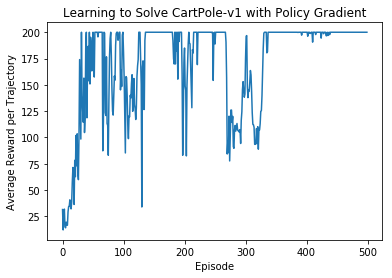

In [ ]:
# Don't forget to close the environments.
monitored_env.close()
env.close()

# Plot learning curve
plt.figure()
plt.plot(traj_reward_history)
plt.title("Learning to Solve CartPole-v1 with Policy Gradient")
plt.xlabel("Episode")
plt.ylabel("Average Reward per Trajectory")
plt.savefig("CartPole-pg.png")
plt.show()
plt.close()
